# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [1]:
install = False
load_model = True
merge_csv = True

In [2]:
# %%capture --no-display
if install:
    %pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook.

In [3]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation
from sympy import simplify
import pickle
import os
import glob
import csv
import pandas as pd
import numpy as np

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [6]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [7]:
def fitness_function_pt(multitree, generation, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for i in range(num_episodes):
    # get initial state of the environment
    observation = env.reset(seed=(generation*1000 + i))
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)/num_episodes
  return fitness, memory

# Evolution Setup & Evolve
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [8]:
# if load_model:
    # %%script false
# else:
if not load_model:
  np.random.seed(42)

  num_features = env.observation_space.shape[0]
  leaf_nodes = [Feature(i) for i in range(num_features)] + [Constant() for _ in range(1)]
  internal_nodes = [Plus(), Minus(), Times(), Div(), Square(), Sqrt(), Log(), Sin(), Cos(), Max(), Min()] #Add your own operators here

  # Run a few times to collect Data
  for i in range(5):
    print(f"------ Evolution {i} ------")
    
    evo = Evolution(
      fitness_function_pt, internal_nodes, leaf_nodes,
      4,
      pop_size=256,
      max_gens=50,
      max_tree_size=31,
      n_jobs=8,
      log_data=True,
      verbose=True)
    
    evo.evolve()

## Save the Evolution

In [9]:
if not load_model:
    with open('baseline.pickle', 'wb') as file:
        pickle.dump(evo, file, pickle.HIGHEST_PROTOCOL)

## Load the Evolution

In [10]:
evo = pickle.load(open('baseline.pickle', 'rb'))

# Testing, visualisation of the results

## Scoring and representation

In [11]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)

        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.mean(rewards)
    
    return fitness

best = evo.best_of_gens[-1]
representation = best.get_readable_repr()


In [12]:
for x in range(len(representation)):
    print("default:")
    print(representation[x])
    print("simple:")
    simpl_repr = simplify(representation[x])
    print(simpl_repr)
    print("\n")
print(get_test_score(best))

default:
sqrt(abs(x_1))
simple:
sqrt(Abs(x_1))


default:
((sqrt(abs(x_1))+(sqrt(abs(x_1))+max(log(abs(x_7)),((x_3*x_5)+x_6))))+(sin(((sqrt(abs(x_1))+x_0)-sin(x_6)))+max(x_3,x_3)))
simple:
x_3 + sin(x_0 - sin(x_6) + sqrt(Abs(x_1))) + 2*sqrt(Abs(x_1)) + Max(x_3*x_5 + x_6, log(Abs(x_7)))


default:
(max(x_7,(x_5)**2)+((log(abs(x_3))+max(sqrt(abs(log(abs(x_2)))),sqrt(abs(x_0))))+sin(cos(x_0))))
simple:
log(Abs(x_3)) + sin(cos(x_0)) + Max(x_5**2, x_7) + Max(sqrt(Abs(x_0)), sqrt(Abs(log(Abs(x_2)))))


default:
((x_5-(sqrt(abs(x_4))-cos(sqrt(abs(sqrt(abs(x_6)))))))/sin(min(cos((cos(x_6)/sin((x_4-x_4)))),x_5)))
simple:
(x_5 + cos(Abs(x_6)**(1/4)) - sqrt(Abs(x_4)))/sin(Min(x_5, cos(zoo*cos(x_6))))




C:\Users\WK\Anaconda3\envs\genepro23\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.2913799299808232


In [13]:
best = evo.best_of_gens[-1]
representation = best.get_readable_repr()
print(representation)
print(get_test_score(best))


['sqrt(abs(x_1))', '((sqrt(abs(x_1))+(sqrt(abs(x_1))+max(log(abs(x_7)),((x_3*x_5)+x_6))))+(sin(((sqrt(abs(x_1))+x_0)-sin(x_6)))+max(x_3,x_3)))', '(max(x_7,(x_5)**2)+((log(abs(x_3))+max(sqrt(abs(log(abs(x_2)))),sqrt(abs(x_0))))+sin(cos(x_0))))', '((x_5-(sqrt(abs(x_4))-cos(sqrt(abs(sqrt(abs(x_6)))))))/sin(min(cos((cos(x_6)/sin((x_4-x_4)))),x_5)))']
0.291379920635771


## Make plots

### Merge runs, by csv

In [14]:
Fit_summation = {}
if merge_csv:
    runs = 5
    max_gens = 50
    Fittest =np.zeros([runs,max_gens]) # initialize array to store fitness values
    i = 0
    j = 0
 
    files = sorted( glob.glob("*.csv"),key=os.path.getmtime )
    # values = [ 1,2,3,4,5,6,7,8 ]

    for file in files:
        value = file.replace(".csv", "")	# max tree size value
        value = value.split("_")[0]

        with open(file, 'r') as f: # open one csv file for a run
            csv_reader = csv.reader(f, delimiter='\t')
            idx=0
            for row in csv_reader:
                try:
                    Fittest[i, idx] =  float(row[1])   # fitness for that generation and run
                except:
                    print("error")
                    print(file)
                    print(row)
                idx+=1    # generation number

        i += 1

        if i == 3:
            i = 0
            j += 1
            new_csv = {value:np.sum(Fittest,axis=0)/5} 
            Fit_summation.update(new_csv)   # one vector with the average of all fitness values for that max tree size
            with open('gen_merge_' + str(value) + '.csv','a') as f1:
                writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
                writer.writerow( zip(range(max_gens), Fit_summation[value]) )    


error
baseline.csv
['(0, -177.8215528740855)', '(1, -128.76918751119442)', '(2, -69.17920906285136)', '(3, -134.79542721478396)', '(4, -34.74860319987156)', '(5, -9.921970504184545)', '(6, -376.6662733635995)', '(7, -26.0886884832512)', '(8, -225.82803452668222)', '(9, -64.35465734701758)', '(10, -287.6538484933794)', '(11, -48.128092473636)', '(12, -52.81316552833148)', '(13, -180.74947979218936)', '(14, -29.49605569142481)', '(15, -38.04634094184585)', '(16, -73.1438138340007)', '(17, -163.85966832385247)', '(18, -68.64185862117816)', '(19, -15.749877693320206)', '(20, -26.73997827924081)', '(21, -117.65494838013123)', '(22, -17.056080720310216)', '(23, -32.751358299337696)', '(24, 2.5531909725568767)', '(25, -23.97950330528045)', '(26, -32.58027007362422)', '(27, -14.351125177241391)', '(28, -25.025552387409512)', '(29, -11.40939382418683)', '(30, -11.555006032863364)', '(31, 17.8790763524651)', '(32, -47.75322484112356)', '(33, 5.075510806792705)', '(34, -57.96232177058598)', '(35,

### Sort csv by run based on numbers given in the csv (not done so will not work)

In [15]:
%%script false
files = sorted( glob.glob("*.csv"),key=os.path.getmtime )
values = [ 1,2,3,4,5,6,7,8,9,10]
a=b=c=d=e=f=g=h=j=k=0
for file in files:
    value = file.replace(".csv", "")	# max tree size value
    value = int(value[17:])
    print(file)
    print(value)
    if value == 1:
        a = a+1
        shutil.copyfile(file, str(value) + "_"+str(a)+'.csv')
    if value == 2:
        b = b+1
        shutil.copyfile(file, str(value) + "_"+str(b)+'.csv')
    if value == 3:
        c = c+1
        shutil.copyfile(file, str(value) + "_"+str(c)+'.csv')
    if value == 4:
        d = d+1
        shutil.copyfile(file, str(value) + "_"+str(d)+'.csv')
    if value == 5:
        e = e+1
        shutil.copyfile(file, str(value) + "_"+str(e)+'.csv')
    if value == 6:
        f = f+1
        shutil.copyfile(file, str(value) + "_"+str(f)+'.csv')
    if value == 7:
        g = g+1
        shutil.copyfile(file, str(value) + "_"+str(g)+'.csv')
    if value == 8:
        h = h+1
        shutil.copyfile(file, str(value) + "_"+str(h)+'.csv')
    if value == 9:
        j = j+1
        shutil.copyfile(file, str(value) + "_"+str(j)+'.csv')
    if value == 10:
        k = k+1
        shutil.copyfile(file, str(value) + "_"+str(k)+'.csv')

Couldn't find program: 'false'


In [16]:
%%script false
values= ['1','2','3','4','5','6','7','8','9','10']
plt.figure( facecolor=(1, 1, 1) )
plt.title ("Variations of atomic functions")
plt.xlabel("Generations")
plt.ylabel("Fitness")
for val in values:
    print(val)
    plt.plot( range(max_gens), Fit_summation[(val)], label=str(val) )
    legned = plt.legend(loc='lower right', shadow=True)
plt.savefig('gen_atomic_fitness.png', format='png', dpi=300)
plt.show()

Couldn't find program: 'false'


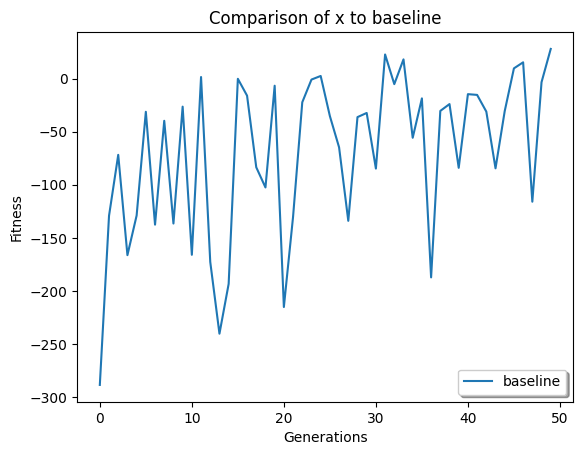

In [21]:
max_gens = 50
values= ['1']
plt.figure( facecolor=(1, 1, 1) )
plt.title ("Comparison of x to baseline")
plt.xlabel("Generations")
plt.ylabel("Fitness")

plt.plot( range(max_gens), Fit_summation['baseline'], label=str("baseline") )
legned = plt.legend(loc='lower right', shadow=True)
plt.savefig('gen_baseline_fitness.png', format='png', dpi=300)
plt.show()

### Direct from CSV fitnesses

In [22]:
def plot(file, every_nth=1, title=None):
    fitnesses = []
    # store all fitnesses in a list
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            fitnesses.append(row)
    fitnesses_array = np.array(fitnesses, dtype=np.float32)  # Transpose for boxplot
    filtered_fit_array = np.ma.masked_invalid(fitnesses_array).T

    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 8))
    ax.set_xlabel("Generation")
    plt.boxplot(filtered_fit_array[:,::every_nth], showfliers=False)
    # plt.xticks(np.arange(0, len(fitnesses), every_nth))
    labels, _ = plt.xticks()
    plt.xticks(labels, labels*every_nth-every_nth)
    if title is not None:
        plt.title(str(title))
    plt.savefig('fig1.png')
    plt.show()

# Manual renaming of the file to be plotted
# plot('fitnesses_baseline_v1.csv', every_nth=2, title='Baseline')
plot('baseline.csv', every_nth=2, title='Baseline')

ValueError: could not convert string to float: '(0, -177.8215528740855)'

### Generate plot for mean fitness

In [39]:
runs = 5
max_gens = 70 
Fittest =np.zeros([runs,max_gens]) # initialize array to store fitness values
i = 0
j = 0

Fit_summation = {}
files = sorted( glob.glob("*.csv"),key=os.path.getmtime )

for file in files:
    value = file.replace(".csv", "")	# max tree size value
    value = value.split("_")[0]
    print(value)

    with open(file, 'r') as f: # open one csv file for a run
        csv_reader = csv.reader(f, delimiter='\t')
        idx=0
        for row in csv_reader:
            try:
                Fittest[i, idx] =  float(row[3])   # fitness for that generation and run
            except:
                print("error")
                print(file)
                print(row)
            idx+=1    # generation number
    i += 1
    if i == 3:
        i = 0
        j += 1
        new_csv = {value:np.sum(Fittest,axis=0)/5} 
        Fit_summation.update(new_csv)   # one vector with the average of all fitness values for that max tree size
        with open('gen_median_' + str(value) + '.csv','a') as f1:
          writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
          writer.writerow( zip(range(max_gens), Fit_summation[value]) )    


fitnesses-2023-06-14-01
fitnesses-2023-06-14-04
fitnesses-2023-06-14-06
fitnesses-2023-06-14-08
fitnesses-2023-06-14-11
baseline
error
baseline.csv
['(0, -177.8215528740855)', '(1, -128.76918751119442)', '(2, -69.17920906285136)', '(3, -134.79542721478396)', '(4, -34.74860319987156)', '(5, -9.921970504184545)', '(6, -376.6662733635995)', '(7, -26.0886884832512)', '(8, -225.82803452668222)', '(9, -64.35465734701758)', '(10, -287.6538484933794)', '(11, -48.128092473636)', '(12, -52.81316552833148)', '(13, -180.74947979218936)', '(14, -29.49605569142481)', '(15, -38.04634094184585)', '(16, -73.1438138340007)', '(17, -163.85966832385247)', '(18, -68.64185862117816)', '(19, -15.749877693320206)', '(20, -26.73997827924081)', '(21, -117.65494838013123)', '(22, -17.056080720310216)', '(23, -32.751358299337696)', '(24, 2.5531909725568767)', '(25, -23.97950330528045)', '(26, -32.58027007362422)', '(27, -14.351125177241391)', '(28, -25.025552387409512)', '(29, -11.40939382418683)', '(30, -11.5550

1


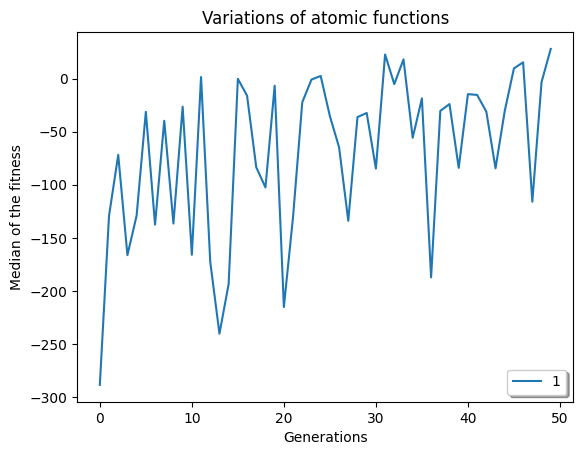

In [23]:
plt.figure( facecolor=(1, 1, 1) )
plt.title ("Variations of atomic functions")
plt.xlabel("Generations")
plt.ylabel("Median of the fitness")
for val in values:
    print(val)
    plt.plot( range(max_gens), Fit_summation['baseline'], label=str(val) )
    legned = plt.legend(loc='lower right', shadow=True)
plt.savefig('gen_atomic_median.png', format='png', dpi=300)
plt.show()

Plot fitness for one run

In [27]:
data = {
    'gen': [],
    'Fit_best': [],
    'Size_best': []
}

df = pd.DataFrame(data)

with open('gen.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        new_row = {'gen': row[0], 'Fit_best': row[1], 'Size_best': row[2]}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

print(df)

                    gen             Fit_best            Size_best
0    -129.0233973101214  -128.51217367988474  -252.81654952393987
1     -607.141413273357  -157.67181965577487   -159.3049089840842
2   -145.11525692954638  -123.77470303172632  -144.37968883489026
3    -377.2814384772042   -38.49711409113801   -869.7535683616294
4    -92.77485322232357   -47.04501184728356   -55.37963854002179
5   -105.44938202237003  -26.264754000897295  -103.21920243846853
6   -115.85232947361472   -941.3726128496662   -46.67502586820984
7   -183.20720241073045   -46.22544049120674   -335.9043511226369
8   -15.985801205325128  -15.985801205325128   -502.2670626696775
9   -28.723918013561065   -259.0495241266814  -27.579917848856297
10   -33.66314286952985    -623.266102084836  -43.486238864067104
11   -1.097528208819662   -243.1835786259764  -14.351733465849662
12   -9.128365562140292  -179.45579168986674   -7.133900312971808
13   -828.6818084131271   -266.9079493717449  -11.368337237804429
14   -55.4

In [25]:
def fitBoxplot(file, every_nth=1):
    fitnesses = []
    # store all fitnesses in a list
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            fitnesses.append(row)
    fitnesses_array = np.array(fitnesses, dtype=np.float32)  # Transpose for boxplot
    filtered_fit_array = np.ma.masked_invalid(fitnesses_array).T

    fig = plt.figure(figsize=(10,5))  # Use this to size the figure
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Generation")
    plt.boxplot(filtered_fit_array[:,::every_nth], showfliers=False)
    # plt.xticks(np.arange(0, len(fitnesses), every_nth))
    labels, _ = plt.xticks()
    plt.xticks(labels, labels*every_nth-every_nth)
    plt.show()

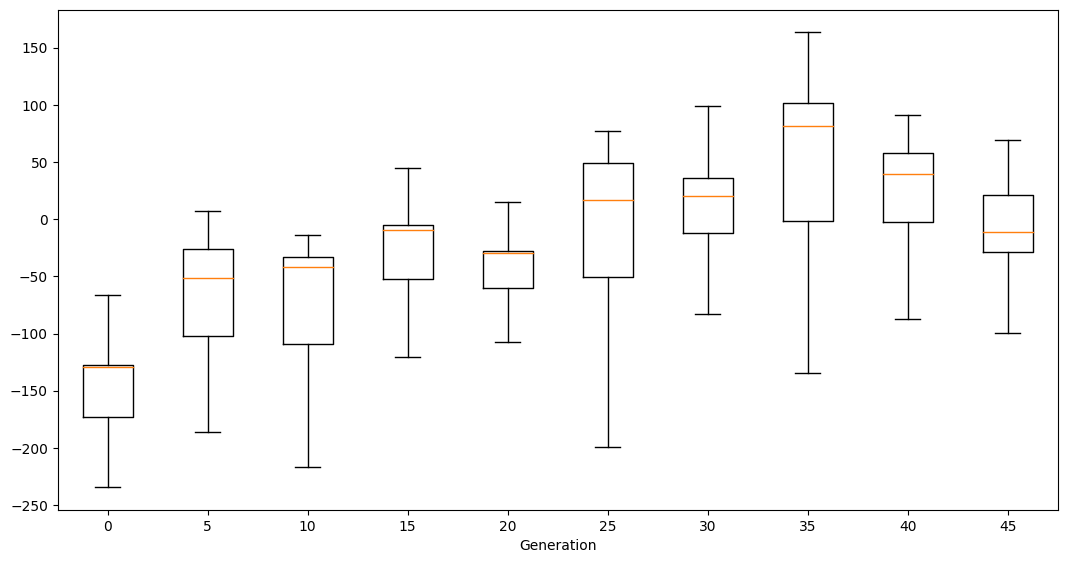

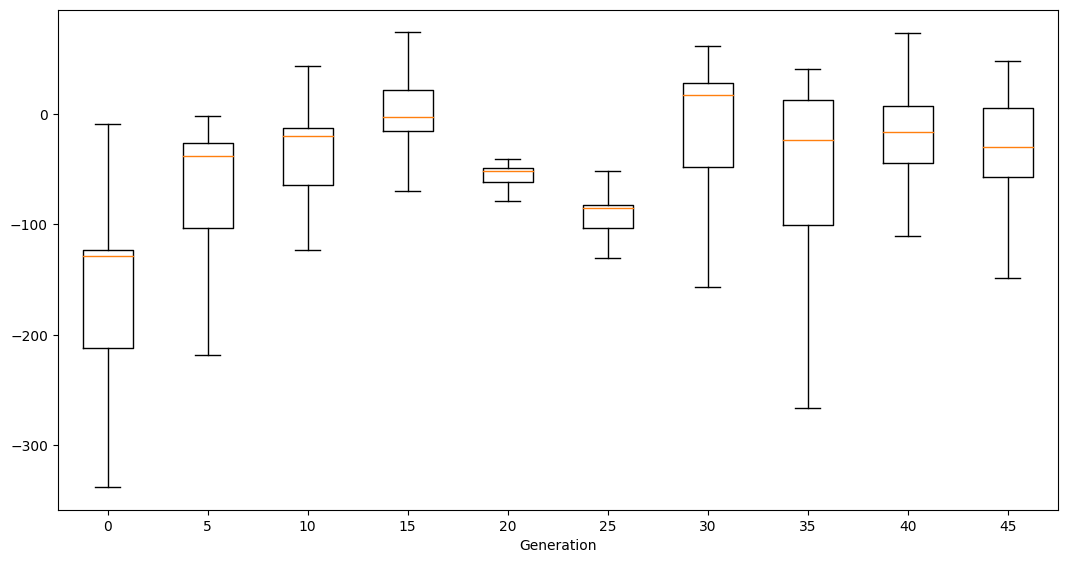

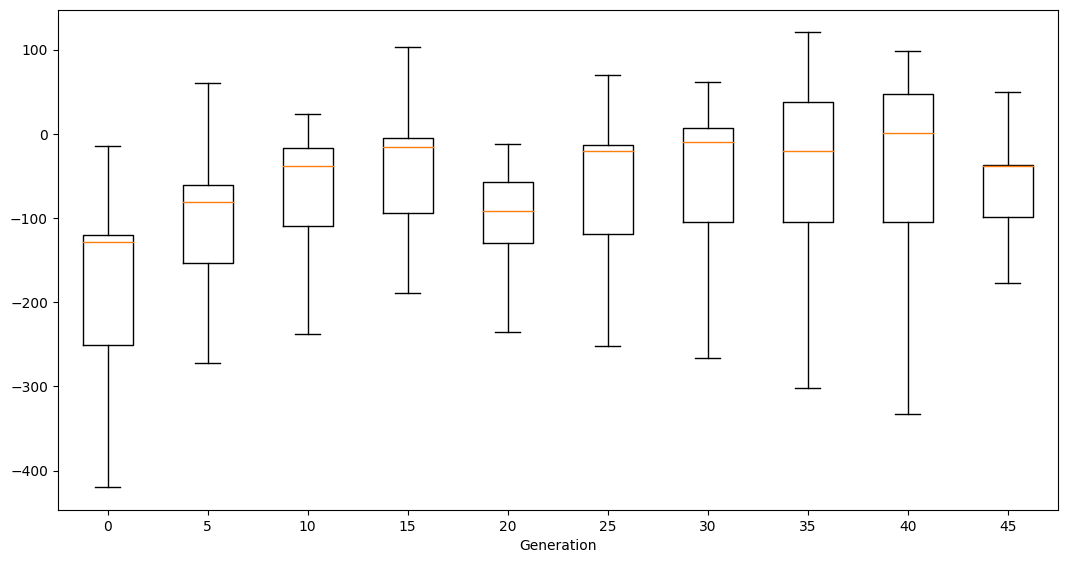

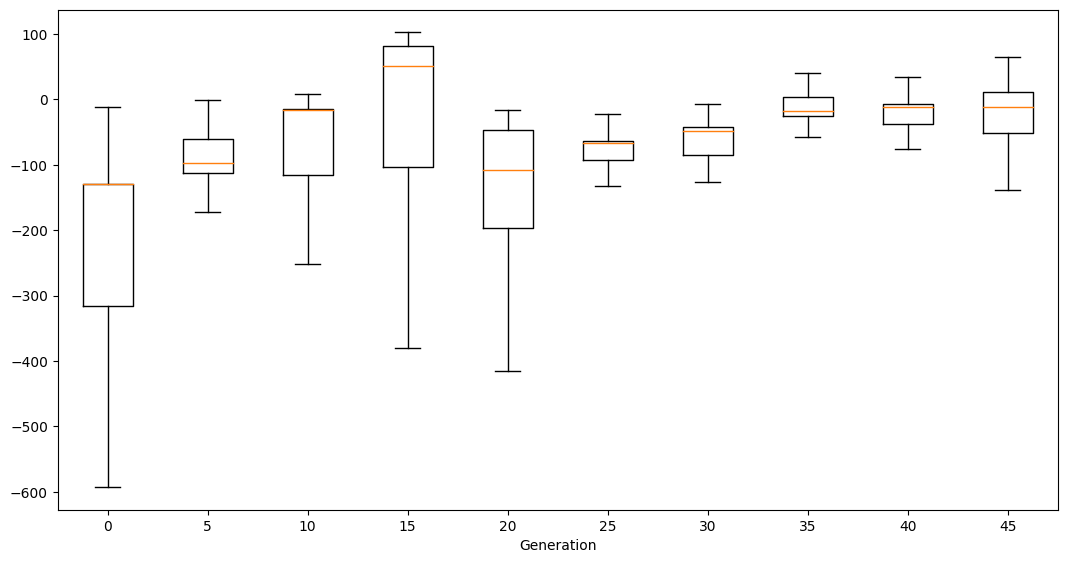

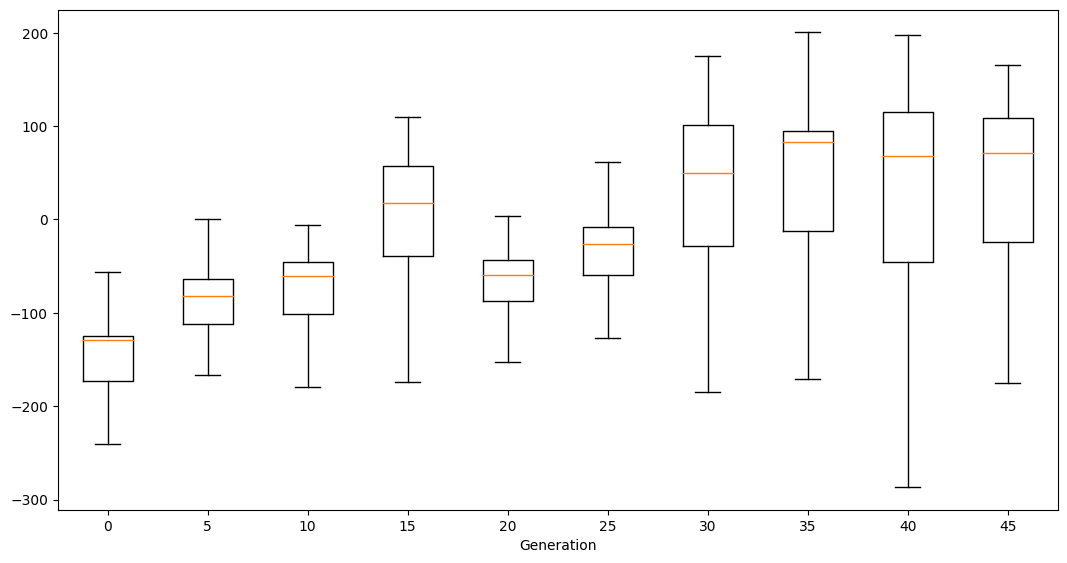

In [26]:
files = sorted( glob.glob("fitness*.csv"),key=os.path.getmtime )
for file in files:
    fitBoxplot(file, every_nth=5)
# This file is on my pc only, get your own fitness file by runing and evlution with save_fitnesses=True
# plot('fitnesses20220617003333.csv', every_nth=5)


## Animations

### Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, generation = 0, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

### Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">